# Домашнее задание 4. Конструирование текстовых признаков из твитов пользователей

## Сбор данных

Первый этап - сбор твитов пользователей. Необходимо подключаться к Twitter API и запрашивать твиты по id пользователя. 
Подключение к API подробно описано в ДЗ 1.

In [1]:
import twitter

CONSUMER_KEY = "eTG832aIi0pyU6EjfoTGge6gx"
CONSUMER_SECRET = "mjvQFaovxMuRJ0U5XpdYfPsmmqiaZFNsL7g4qkk942OdDip6hG"

ACCESS_TOKEN_KEY = "780018504787488769-KVrRy17YTgqcUzrM32ykuYipvptNKvB"
ACCESS_TOKEN_SECRET = "qtZmbBAiOrzaBxwGNdlP0bfVA3cz2AWmsv0kq1jfdIOEb"

api = twitter.Api(consumer_key=CONSUMER_KEY, 
                  consumer_secret=CONSUMER_SECRET, 
                  access_token_key=ACCESS_TOKEN_KEY, 
                  access_token_secret=ACCESS_TOKEN_SECRET,
                  sleep_on_rate_limit=True)

Для получения твитов пользователя может быть использован метод GetUserTimeline из библиотеки python-twitter. Он позволяет получить не более 200 твитов пользователя. По каждому пользователю достаточно собрать 200 твитов.

Метод имеет ограничение по количеству запросов в секунду. Для получения информации о промежутке времени, которое необходимо подождать для повторного обращения к API может быть использован метод `GetSleepTime`. Для получения информации об ограничениях запросов с помощью метода `GetUserTimeLine` необходимо вызывать `GetSleepTime` с параметром "statuses/user_timeline".

Метод GetUserTimeline возвращает объекты типа Status. У этих объектов есть метод AsDict, который позволяет представить твит в виде словаря.

Id пользователей необходимо считать из файла, как было сделано в ДЗ 1.

Необходимо реализовать функцию `get_user_tweets(user_id)`. Входной параметр - id пользователя из файла. Возвращаемое значение - массив твитов пользователя, где каждый твит представлен в виде словаря. Предполагается, что информация о пользователе содержится в твитах, которые пользователь написал сам. Это означает, что можно попробовать отфильтровать ответы другим пользователям, ссылки и ретвиты, а так же картинки и видео, так как наша цель - найти текстовую информацию.

In [2]:
def get_user_tweets(user_id):
    """returns list of tweets as dicts"""
    
    userTimeline = api.GetUserTimeline(user_id, count=200, include_rts=False, trim_user=True, exclude_replies=True)
    tweets = []
    for tweet in userTimeline:
        tweets.append(tweet.AsDict())
        
    return tweets

## Разбор текста твита

Обработка текста предполагает разбиение текста на отдельные элементы - параграфы, предложения, слова. Мы будем преобразовывать текст твита к словам. Для этого текст необходимо разбить на слова. Сделать это можно, например, с помощью регулярного выражения.

Необходимо реализовать функцию, `get_words(text)`. Входной параметр - строка с текстом. Возвращаемое значение - массив строк (слов). Обратите внимание, что нужно учесть возможное наличие пунктуации и выделить по возможности только слова. 

In [81]:
import unicodedata
import nltk
import re


def get_words(text):
    """returns list of words"""
    #normalize
    normalized_string = ''.join(c for c in unicodedata.normalize('NFD', text.lower()) if not unicodedata.combining(c))
    #strip URLs
    normalized_string = re.sub(r'https?:\/\/[\w/.]+', '', normalized_string, flags=re.MULTILINE)
    #strip hashtags
    normalized_string = re.sub(r'#[\w]+', '', normalized_string, flags=re.MULTILINE)
    #split
    tokenizer = nltk.RegexpTokenizer('\w+')
    return tokenizer.tokenize(normalized_string)

In [84]:
print get_words(u"Here are different words!")

[u'here', u'are', u'different', u'words']


Далее полученные слова необходимо привести к нормальной форме. То есть привести их к форме единственного числа настоящего времени и пр. Сделать это можно с помощью библиотеки nltk. Информацию по загрузке, установке библиотеки и примерах использования можно найти на сайте http://www.nltk.org/

Для загрузки всех необходимых словарей можно воспользоваться методом download из библиотеки nltk.

In [5]:
import nltk
#nltk.download()

Для дальнейшей обработки слова должны быть приведены к нижнему регистру. 

Для приведения к нормальной форме можно использовать `WordNetLemmatizer` из библиотеки nltk. У этого класса есть метод `lemmatize`.

Также необходимо убрать из текста так называемые стоп-слова. Это часто используемые слова, не несущие смысловой нагрузки для наших задач. Сделать это можно с помощью `stopwords` из nltk.corpus

Необходимо реализовать функцию `get_tokens(words)`. Входной параметр - массив слов. Возвращаемое значение - массив токенов.

In [6]:
def get_tokens(words):
    """returns list of tokens"""
    # your code here
    wnl = nltk.stem.wordnet.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english')
    tokens = []
    for word in words:
        lem = wnl.lemmatize(word)
        if lem not in stopwords:
            tokens.append(lem)
    return tokens

In [98]:
print get_tokens(["here", "are", "different", "words"])

['different', u'word']


Необходимо реализовать функцию `get_tweet_tokens(tweet)`. Входной параметр - текст твита. Возвращаемое значение -- токены твита. 

In [8]:
def get_tweet_tokens(tweet):
    # your code here
    return get_tokens(get_words(tweet))

In [14]:
get_tweet_tokens(u"Here are different words!")

[u'different', u'word']

Необходимо реализовать функцию `collect_users_tokens()`. Функция должна сконструировать матрицу признаков пользователей. В этой матрице строка - пользователь. Столбец - токен. На пересечении - сколько раз токен встречается у пользователя.
Для построения матрицы можно использовать `DictVectorizer` из `sklearn.feature_extraction`.

In [86]:
#user_tokens = {}

In [124]:
import pickle
def save_tweets():
    with open('user_tokens.pkl', 'wb') as f:
        pickle.dump(user_tokens, f, pickle.HIGHEST_PROTOCOL)

def load_tweets():
    with open('user_tokens.pkl', 'rb') as f:
        return pickle.load(f)


In [12]:
#downloaded_tweets = load_tweets()

In [125]:
#save_tweets()

In [128]:
from tqdm import tqdm
def collect_users_tokens(df_users):
    """returns users list and list of user dicts. Each dict contains frequence of user tokens"""
    # your code here
    # save intermediate result
    for uid in tqdm(df_users['uid']):
        if uid in user_tokens: continue
        user_tokens[uid] = {}    
        try:
            tweets = get_user_tweets(uid)
            for tweet in tweets:
                tokens = get_tweet_tokens(tweet['text'])
                for token in tokens:
                    if token in user_tokens[uid]:
                       user_tokens[uid][token] += 1
                    else:
                        user_tokens[uid][token] = 1
        except twitter.TwitterError:
            pass
    uids = user_tokens.keys()
    tokens_list = [user_tokens[uid] for uid in uids]
    return uids, tokens_list


In [129]:
import pandas as pd
from collections import defaultdict
import json
from sklearn.feature_extraction import DictVectorizer


TRAINING_SET_URL = "train.csv"
EXAMPLE_SET_URL = "test.csv"
df_users_train = pd.read_csv(TRAINING_SET_URL, sep=",", header=0, names=["uid", "cat"])
df_users_ex = pd.read_csv(EXAMPLE_SET_URL, sep=",", header=0, names=["uid"])
df_users_ex['cat'] = None
df_users = pd.concat([df_users_train, df_users_ex])

users, users_tokens = collect_users_tokens(df_users)
v = DictVectorizer()
vs = v.fit_transform(users_tokens)

In [131]:
import numpy as np
np.savez("out_4.dat", data=vs, users=users, users_tokens=users_tokens )

Далее для получения представления о полученной информацию о токенах предлагается отобразить ее в виде облака тэгов. [Подсказка](http://anokhin.github.io/img/tag_cloud.png). 

/home/dima/anaconda2/lib/python2.7/site-packages/ipykernel/pylab/config.py:66: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  inline backend."""
/home/dima/anaconda2/lib/python2.7/site-packages/ipykernel/pylab/config.py:71: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  'retina', 'jpeg', 'svg', 'pdf'.""")
/home/dima/anaconda2/lib/python2.7/site-packages/ipykernel/pylab/config.py:85: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  use `figure_formats` instead)""")
/home/dima/anaconda2/lib/python2.7/site-packages/ipykernel/pylab/config.py:95: DeprecationWarning: metadata {'config': True} was set from the constructor. 

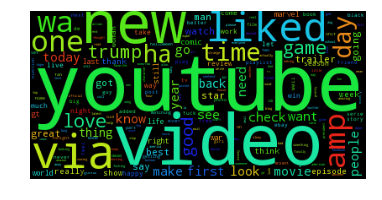

In [147]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

def draw_tag_cloud(v, vs):
    """Draws tag cloud of found tokens"""
    # your code here
    tokens_list = v.inverse_transform(vs)
    text = ''
    for tokens in tokens_list:
        text += ''.join((key+' ')*tokens[key] for key in tokens.keys())
    wordcld = WordCloud().generate(text)
    plt.imshow(wordcld)
    plt.axis("off")
    plt.show()
    return
draw_tag_cloud(v, vs)